# Research Assistant Agent


In [1]:
# Built-in library
import asyncio
import json
import logging
import re
import warnings
from pathlib import Path
from pprint import pprint
from typing import (
    Annotated,
    Any,
    Generator,
    Iterable,
    Literal,
    Optional,
    TypedDict,
    Union,
)

# Standard imports
import nest_asyncio
import numpy as np
import numpy.typing as npt
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "white": "#FFFFFF",  # Bright white
        "info": "#00FF00",  # Bright green
        "warning": "#FFD700",  # Bright gold
        "error": "#FF1493",  # Deep pink
        "success": "#00FFFF",  # Cyan
        "highlight": "#FF4500",  # Orange-red
    }
)
console = Console(theme=custom_theme)

# Visualization
# import matplotlib.pyplot as pltife

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def go_up_from_current_directory(*, go_up: int = 1) -> None:
    """This is used to up a number of directories.

    Params:
    -------
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.

    Returns:
    --------
    None
    """
    import os
    import sys

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)

In [3]:
go_up_from_current_directory(go_up=2)


from schemas import ModelEnum  # noqa: E402
from settings import refresh_settings  # noqa: E402
from utilities.client_utils import check_rate_limit  # noqa: E402

settings = refresh_settings()

/Users/neidu/Desktop/Projects/Personal/My_Projects/AI-Tutorials


In [4]:
from IPython.display import Image, Markdown, display
from langchain.chat_models import init_chat_model
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langchain_litellm import ChatLiteLLM
from langchain_tavily import TavilySearch
from langfuse.callback import CallbackHandler
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

### Goal

- Build a lightweight, multi-agent system using chat models to customize the research process.

### Key Themes

- Integrates LangGraph themes like memory, human-in-the-loop, and controllability.

### Source Selection

- Allows users to choose input sources for their research.

### Planning

- Users provide a topic.
- The system generates a team of AI analysts, each focusing on a sub-topic.
- Human-in-the-loop will be used to refine sub-topics before research starts.

### LLM Utilization (Research Process)

- Each analyst conducts in-depth, multi-turn interviews with an expert AI based on selected sources, similar to the STORM paper.
- Interviews are captured in sub-graphs with internal state.
- Experts gather information in parallel and interviews are conducted simultaneously via map-reduce.

### Output Format

- Gathered insights from each interview are synthesized into a final report.
- Customizable prompts allow for flexible report output.

In [5]:
from langchain_core.language_models.chat_models import BaseChatModel

model_str: str = "mistralai:open-mixtral-8x22b"
llm: BaseChatModel = init_chat_model(model=model_str, temperature=0.0)


llm = init_chat_model(
    model_provider="openai",
    openai_api_key=settings.OPENROUTER_API_KEY.get_secret_value(),
    base_url=settings.OPENROUTER_URL,
    model="openai/gpt-4o-mini",
)

In [6]:
question = "Who be Tinubu?"

print(llm.invoke(question).content)

Bola Ahmed Tinubu is a Nigerian politician and the President of Nigeria, having taken office on May 29, 2023. He is a member of the All Progressives Congress (APC) and was formerly the Governor of Lagos State from 1999 to 2007. Tinubu is a key figure in Nigerian politics and is often referred to as a political godfather in Lagos and beyond, having played instrumental roles in the formation and success of various political parties in the country. His tenure as governor is noted for various reforms in Lagos State, particularly in public transport and infrastructure development. Tinubu's political influence continues to be significant in Nigeria’s political landscape.


## Create Analysts: Human-in-the-loop

- Create analysts and review them using human-in-the-loop.

In [7]:
from pydantic import BaseModel, Field


class Analyst(BaseModel):
    affiliation: str = Field(description="The primary affiliation of the analyst.")
    role: str = Field(description="The role of the analyst.")
    name: str = Field(description="The name of the analyst.")
    description: str = Field(
        description="The description of the analyst's focus, concerns and motives."
    )

    @property
    def persona(self) -> str:
        return (
            f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}"
            f"\nDescription: {self.description}"
        )


class Perpectives(BaseModel):
    analysts: list[Analyst] = Field(
        description="A list of analysts with their detailed information."
    )


class GenerateAnalystState(TypedDict):
    topic: str  # Research topic
    max_analyst: int  # Maximum number of analysts
    human_analyst_feedback: str  # Human feedback
    analysts: list[Analyst]  # Analyst asking questions

In [8]:
analyst_instructions: str = """
<instruction>
You're tasked with creating a set of AI analyst personas. Follow these instructions carefully:
1. First, review the reseacrch topic: \n{topic}
2. Examine any editorial feedback that has been optionally provided to guide the creation of the analysts:
{human_analyst_feedback}
3. Determine the most interesting themes based upon documents and/or feedback above.
4. Pick the top {max_analyst} themes.
5. Assign one analyst to each theme.
</instruction>
"""


async def create_analysts(state: GenerateAnalystState) -> dict[str, Any]:
    topic: str = state["topic"]
    max_analyst: int = state["max_analyst"]
    human_analyst_feedback: str = state.get("human_analyst_feedback", "")

    structured_llm = llm.with_structured_output(Perpectives)
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analyst=max_analyst,
    )
    analysts = await structured_llm.ainvoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content="Generate the set of analysts.")]
    )

    return {"analysts": analysts.analysts}


def human_feedback(state: GenerateAnalystState) -> None:
    pass


def should_continue(state: GenerateAnalystState) -> Literal["create_analysts", END]:
    human_analyst_feedback = state.get("human_analyst_feedback", None)
    if human_analyst_feedback:
        return "create_analysts"

    return END

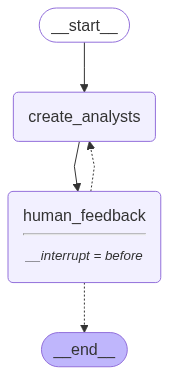

In [9]:
from langgraph.graph.state import CompiledStateGraph


graph_builder = StateGraph(GenerateAnalystState)

# Add nodes
graph_builder.add_node("create_analysts", create_analysts)
graph_builder.add_node("human_feedback", human_feedback)

# Add edges
graph_builder.add_edge(START, "create_analysts")
graph_builder.add_edge("create_analysts", "human_feedback")
# Add conditions
graph_builder.add_conditional_edges(
    "human_feedback", should_continue, ["create_analysts", END]
)

# Compile the graph
memory = MemorySaver()
langfuse_handler = CallbackHandler()
graph: CompiledStateGraph = graph_builder.compile(
    interrupt_before=["human_feedback"], checkpointer=memory
).with_config({"callbacks": [langfuse_handler]})

# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

#### Test The Code

In [10]:
# Inputs
max_analyst: int = 3
topic: str = "The benefits of Christianity"
thread: dict[str, Any] = {"configurable": {"thread_id": "1"}}

# Run the graph
async for event in graph.astream(
    {"topic": topic, "max_analyst": max_analyst}, thread, stream_mode="values"
):
    analysts = event.get("analysts", "")

    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Role: {analyst.role}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Carter
Role: Cultural Analyst
Affiliation: Harvard Divinity School
Description: Dr. Emily Carter focuses on the cultural impacts of Christianity, exploring how Christian values influence social behavior and community cohesion. Her research emphasizes the positive societal transformations brought about by Christian teachings.
--------------------------------------------------
Name: Professor Johnathan Blake
Role: Theological Researcher
Affiliation: Oxford University Press
Description: Professor Johnathan Blake specializes in theological studies, analyzing the spiritual benefits of Christianity. He examines how Christian beliefs shape individual purpose, morality, and psychological well-being, advocating for the role of faith in leading a fulfilling life.
--------------------------------------------------
Name: Dr. Sarah Gonzalez
Role: Sociological Analyst
Affiliation: Pew Research Center
Description: Dr. Sarah Gonzalez conducts sociological studies to understand the demo

In [11]:
# Get the state and look at the next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [12]:
# The next step is t update the state as if we're the human_feedback node
graph.update_state(
    thread,
    {
        "human_analyst_feedback": "Add a priest to add some apostolic and traditional perspective"
    },
    as_node="human_feedback",
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f04324e-9e73-639c-8002-6be0d4289ac4'}}

In [13]:
# Continue the graph execution
input_: dict[str, Any] | None = None  # Continue the graph execution

# Run the graph
async for event in graph.astream(input_, thread, stream_mode="values"):
    analysts = event.get("analysts", "")

    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Role: {analyst.role}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Carter
Role: Cultural Analyst
Affiliation: Harvard Divinity School
Description: Dr. Emily Carter focuses on the cultural impacts of Christianity, exploring how Christian values influence social behavior and community cohesion. Her research emphasizes the positive societal transformations brought about by Christian teachings.
--------------------------------------------------
Name: Professor Johnathan Blake
Role: Theological Researcher
Affiliation: Oxford University Press
Description: Professor Johnathan Blake specializes in theological studies, analyzing the spiritual benefits of Christianity. He examines how Christian beliefs shape individual purpose, morality, and psychological well-being, advocating for the role of faith in leading a fulfilling life.
--------------------------------------------------
Name: Dr. Sarah Gonzalez
Role: Sociological Analyst
Affiliation: Pew Research Center
Description: Dr. Sarah Gonzalez conducts sociological studies to understand the demo

In [14]:
# If we're satisfied, then we simply supply no feedback
further_feedback: str | None = None
graph.update_state(
    thread, {"human_analyst_feedback": further_feedback}, as_node="human_feedback"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f04324e-c99c-6aaa-8004-57394718a812'}}

In [15]:
# Continue the graph execution to the end
input_: dict[str, Any] | None = None  # Continue the graph execution
thread: dict[str, Any] = {"configurable": {"thread_id": "1"}}

# Run the graph
async for event in graph.astream(
    input_,
    thread,
    stream_mode="updates",  # NEW - Use "updates" instead of "values"
):
    print("--Node--")
    print(f"Role: {analyst.role}")
    node_name: str = next(iter(event.keys()))
    print(node_name)

In [16]:
final_state = graph.get_state(thread)
analysts = final_state.values.get("analysts")

In [17]:
final_state.next

()

In [18]:
# Run the graph
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Role: {analyst.role}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Description: {analyst.description}")
    print("-" * 50)

Name: Father Thomas
Role: Priest
Affiliation: St. Michael's Church
Description: Father Thomas provides a traditional perspective on the benefits of Christianity, focusing on spiritual growth, community support, and moral guidance rooted in apostolic teachings.
--------------------------------------------------
Name: Dr. Sarah Johnson
Role: Social Science Analyst
Affiliation: Faith and Values Research Institute
Description: Dr. Sarah Johnson specializes in the social benefits of Christianity, examining its impact on community cohesion, social justice, and humanitarian efforts within diverse populations.
--------------------------------------------------
Name: Professor Michael Chen
Role: Theologian
Affiliation: Theological Educational Institute
Description: Professor Michael Chen focuses on the theological benefits of Christianity, exploring how Christian doctrine contributes to personal purpose, ethical decision-making, and philosophical inquiry into the meaning of life.
--------------

## Conduct Interview

- The analyst will ask questions to the experts

In [19]:
class InterviewState(MessagesState):
    max_num_turns: int  # The maximum number of turns of conversation
    context: Annotated[list[Any], add_messages]  # The context of the conversation
    analyst: Analyst  # Analyst asking the question
    interview: str  # Interview transcript
    sections: list[Any]  # Final key used with the Send() method


class SearchQuery(BaseModel):
    search_query: str | None = Field(
        default=None, description="Search query for retieval"
    )


question_instructions: str = """
<instruction>
You're an analyst tasked with interviewing an expert to learn about a specific topic. Your
goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising and non-obvious.
2. Specific: Insights that avoid generalities and include specific examples from the expert.

<goals>
Here is your topic of focus and set of goals: {goals}
</goals>

Begin by introducing yourself using a name that fits your persona, and then ask your question.
Continue to ask questions to drill down and refine your understanding of the topic. When you
are satisfied with your understanding, complete the interview by responding: 
<response>"Thank you so much for your help!"</response>

Remember to stay in character throughout your response, reflecting the persona and goals provided to you
</instruction>
"""

print(question_instructions)


<instruction>
You're an analyst tasked with interviewing an expert to learn about a specific topic. Your
goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising and non-obvious.
2. Specific: Insights that avoid generalities and include specific examples from the expert.

<goals>
Here is your topic of focus and set of goals: {goals}
</goals>

Begin by introducing yourself using a name that fits your persona, and then ask your question.
Continue to ask questions to drill down and refine your understanding of the topic. When you
are satisfied with your understanding, complete the interview by responding: 
<response>"Thank you so much for your help!"</response>

Remember to stay in character throughout your response, reflecting the persona and goals provided to you
</instruction>



<br>

### Generate Questions And Answers In Parallel

- The expert will gather info from multiple sources in parallel to answer questions.
- For example, we can use:
  - Specific websites
  - Indexed documents via RAG
  - Web search
  - Wikipedia search

In [20]:
from langchain_community.document_loaders import WikipediaLoader

# Web search tool
tavily_search = TavilySearch(max_results=3)


search_instructions: str = """
<instruction>
You will be given a conversation between an analyst and an expert.

<goal>
Your goal is to generate a well-structured query for use in retrieval and / or web-search 
related to the conversation.
</goal>

First, analyze the full conversation. Pay particular attention to the final question posed 
by the analyst.
Convert this final question into a well-structured web search query.
</instruction>
"""


answer_instructions: str = """
<instruction>
You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}.         
You goal is to answer a question posed by the interviewer.

To answer question, use this context:        
{context}

<guidelines>
When answering questions, follow these guidelines:
1. Use only the information provided in the context. 
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.
3. The context contain sources at the topic of each individual document.
4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 
5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
[1] assistant/docs/llama3_1.pdf, page 7 
And skip the addition of the brackets as well as the Document source preamble in your citation.
</guidelines>

</instruction>
"""


section_writer_instructions: str = """
<instruction>
You are an expert technical writer. 
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/

8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed
</instruction>
"""

In [21]:
question_instructions = """
<instruction>
You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}

Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.

When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you.
</instruction>
"""

In [22]:
message: str = "Tell me a who the current Pope is."
search_query: SearchQuery = await llm.with_structured_output(SearchQuery).ainvoke(
    [SystemMessage(content=search_instructions)] + [message]
)
search_docs = await tavily_search.ainvoke(search_query.search_query)

search_docs

{'query': 'current Pope 2023',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Pope Francis - Wikipedia',
   'url': 'https://en.wikipedia.org/wiki/Pope_Francis',
   'content': 'Pope Francis [b] (born Jorge Mario Bergoglio; [c] 17 December 1936 - 21 April 2025) was head of the Catholic Church and sovereign of the Vatican City State from 2013 until his death in 2025. He was the first Jesuit pope, the first Latin American, and the first born or raised outside Europe since the 8th-century Syrian pope Gregory III.',
   'score': 0.68496037,
   'raw_content': None},
  {'title': 'After 10 years as pope, Francis continues to reshape the Catholic ... - NPR',
   'url': 'https://www.npr.org/2023/03/13/1162954465/after-10-years-as-pope-francis-continues-to-reshape-the-catholic-church',
   'content': 'After 10 years as pope, ... March 13, 2023 5:47 AM ET. Sylvia Poggioli After 10 years as pope, Francis continues to reshape the Catholic Church. Listen · 8:03 8:03

In [ ]:
search_query: SearchQuery = await llm.with_structured_output(SearchQuery).ainvoke(
    [SystemMessage(content=search_instructions)] + [message]
)
search_docs = WikipediaLoader(search_query.search_query, load_max_docs=2).load()
search_docs

In [ ]:
from langchain_core.messages import get_buffer_string


async def generate_question(state: InterviewState) -> dict[str, Any]:
    # Get state
    analyst: Analyst = state["analyst"]
    messages: list[Any] = state["messages"]

    # Generate questions
    system_message = question_instructions.format(goals=analyst.persona)
    question = await llm.ainvoke([SystemMessage(content=system_message)] + messages)

    # Write the message to the state
    return {"question": question}


async def search_web(state: InterviewState) -> dict[str, Any]:
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query: SearchQuery = await structured_llm.ainvoke(
        [SystemMessage(content=search_instructions)] + state["messages"]
    )

    # Search web
    search_docs = await tavily_search.ainvoke(search_query.search_query)

    formatted_search_docs = "\n\n ---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs.get("results")
        ]
    )

    return {"context": [formatted_search_docs]}


async def search_wikipedia(state: InterviewState) -> dict[str, Any]:
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query: SearchQuery = await structured_llm.ainvoke(
        [SystemMessage(content=search_instructions)] + state["messages"]
    )

    # Search wikipedia
    search_docs = WikipediaLoader(search_query.search_query, load_max_docs=2).load()

    formatted_search_docs = "\n\n ---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" '
            f'page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


async def generate_answer(state: InterviewState) -> dict[str, Any]:
    # Get state
    analyst: Analyst = state["analyst"]
    messages: list[Any] = state["messages"]
    context: list[Any] = state["context"]

    # Answer questions
    system_message: str = answer_instructions.format(
        goals=analyst.persona, context=context
    )
    answer = await llm.ainvoke([SystemMessage(content=system_message)] + messages)
    answer.name = "expert"  # Add a name to the answer

    # Write the message to the state
    return {"answer": [answer]}


def save_interview(state: InterviewState) -> dict[str, Any]:
    messages = state["messages"]
    # Convert interview to string
    interview = get_buffer_string(messages)

    return {"interview": interview}


def route_messages(
    state: InterviewState, name: str = "expert"
) -> Literal["ask_question", "save_interview"]:
    messages: list[Any] = state["messages"]
    max_num_turns: int = state.get("max_num_turns", 2)

    # Check the number of responses by the `expert`
    num_responses: int = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    # End if the `expert` has answered more than `max_num_turns`
    if num_responses >= max_num_turns:
        return "save_interview"

    # Get the last qs asked to check if it signals the end of the interview
    try:
        last_message = messages[-2]
        if "thank you so much for your help" in last_message.content.lower():
            return "save_interview"
    except IndexError:
        return "ask_question"

    return "ask_question"


async def write_section(state: InterviewState) -> dict[str, Any]:
    # Get state
    context: list[Any] = state["context"]
    analyst: Analyst = state["analyst"]

    # Create the source doc using either the context or the interview
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = await llm.ainvoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content=f"Use this source to write your section: {context}")]
    )

    # Write the message to the state
    return {"sections": [section.content]}

In [ ]:
from langchain_core.runnables import RunnableConfig


# Create graph
graph_builder = StateGraph(InterviewState)

# Add nodes
graph_builder.add_node("search_web", search_web)
graph_builder.add_node("search_wikipedia", search_wikipedia)
graph_builder.add_node("ask_question", generate_question)
graph_builder.add_node("answer_question", generate_answer)
graph_builder.add_node("save_interview", save_interview)
graph_builder.add_node("write_section", write_section)

# Connect nodes
graph_builder.add_edge(START, "ask_question")
graph_builder.add_edge("ask_question", "search_wikipedia")
graph_builder.add_edge("ask_question", "search_web")
graph_builder.add_edge("search_web", "answer_question")
graph_builder.add_edge("search_wikipedia", "answer_question")
graph_builder.add_conditional_edges(
    "answer_question", route_messages, ["ask_question", "save_interview"]
)
graph_builder.add_edge("save_interview", "write_section")
graph_builder.add_edge("write_section", END)

# Compile the graph
memory = MemorySaver()
langfuse_handler = CallbackHandler()
config = RunnableConfig(callbacks=[langfuse_handler], run_name="Conduct Interviews")
graph: CompiledStateGraph = graph_builder.compile(checkpointer=memory).with_config(
    config
)

# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Pick one analyst
console.log(analysts[0])

In [ ]:
messages = [
    HumanMessage(content=f"So you said you were writing an article on {topic}?")
]
thread: dict[str, Any] = {"configurable": {"thread_id": "1"}}
input_values: dict[str, Any] = {
    "analyst": analysts[0],
    "messages": messages,
    "max_num_turns": 2,
}

interview = await graph.ainvoke(input_values, thread)

Markdown(interview["sections"][0])

In [ ]:
/no_think

In [ ]:
{
    "query": "current Pope",
    "follow_up_questions": None,
    "answer": None,
    "images": [],
    "results": [
        {
            "title": "Pope Leo XIV - Wikipedia",
            "url": "https://en.wikipedia.org/wiki/Pope_Leo_XIV",
            "content": "Pope Leo XIV [a] (born Robert Francis Prevost, [b] [c] September 14, 1955) ...",
            "score": 0.73755574,
            "raw_content": None,
        },
        ...,
    ],
    "response_time": 1.79,
}